In [1]:
from ZV_functions import *
import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
matplotlib.rcParams.update({'font.size': 16})
import tensorflow as tf
from keras.layers import Dense, Dropout, LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from keras.constraints import maxnorm
import keras.backend as k
from tensorflow.keras import regularizers


Using TensorFlow backend.


In [2]:
#base_dir='/eos/home-a/ahakimi/www/ZV_analysis'
base_dir='D:\\Travail\\ZV_analysis\\'
year='2018_SR_new'
cut='Boosted_SR'
vers=''

data_dir=base_dir+year+'\\'+cut+'\\data'+vers



if cut == 'Boosted_SR':
    features =['pt1', 'pt2', 'eta1',
           'eta2', 'mll',
           'FatJet_pt', 'FatJeteta',
           'Zlep_1', 'Zlep_2', 
           'vbs_jet_pt1', 'vbs_jet_pt2',
           'vbs_jet_eta1', 'vbs_jet_eta2',
           'mjj_max', 'detajj_mjjmax']
elif cut == 'Resolved_SR':
    features=['pt1', 'pt2', 'eta1',
           'eta2', 'mll',
           'Zlep_1', 'Zlep_2', 
           'vbs_jet_pt1', 'vbs_jet_pt2',
           'vbs_jet_eta1', 'vbs_jet_eta2',
           'V_jet_pt1', 'V_jet_pt2',
           'V_jet_eta1', 'V_jet_eta2',
           'mjj_max', 'detajj_mjjmax',
           'V_jet_mass']

input_list= features
inputs= [cut+'_'+i for i in input_list]



In [3]:
X,y, variables_list=prep_data(year, cut, vers, base_dir) #

xlims=[(0,200),(0,150),(-3,3),(-3,3),(0,150),(0,5),(0,10),(0,900),(-5,5),(0,200),(0,1),(-1.5,1.5),(-1.5,1.5),(-1,1),
       (0,200),(0,200),(-5,5),(-5,5),
           (0,200),(0,100),(-5,5),(-5,5),(0,3000),(0,10),(0,4),(0,150)]

#plot_distrib(variables_list, xlims,base_dir, year, cut)
print('NUmber of events: {}, signal : {}, bkg: {}'.format(len(y),len(y[y['signal']==1]),len(y[y['signal']==0])))
print('SOW: {}, signal : {}, bkg: {}'.format(sum(y['weight_']),sum(y['weight_'][y['signal']==1]),sum(y['weight_'][y['signal']==0])))

Boosted_SR_pt1 147.63426 104.01022
Boosted_SR_pt2 60.33027 41.43365
Boosted_SR_eta1 -0.0097989645 1.2106419
Boosted_SR_eta2 -0.0043315254 1.2114636
Boosted_SR_mll 90.81821 4.24836
Boosted_SR_Zepp_ll 0.7101834 0.7125248
Boosted_SR_nFatJet 2.1728036696590154 0.7309738046018177
Boosted_SR_FatJet_pt 307.9248 160.39818
Boosted_SR_FatJeteta -5.1237793 71.33908
Boosted_SR_FatJet_softdropmass 85.68005 12.686821
Boosted_SR_FatJet_tau21 -4.7904153 71.3557
Boosted_SR_Zlep_1 -0.0085312715 0.5673623
Boosted_SR_Zlep_2 -0.00710825 0.5831202
Boosted_SR_category 0.0 0.0
Boosted_SR_vbs_jet_pt1 219.50323 158.23256
Boosted_SR_vbs_jet_pt2 70.87412 54.013393
Boosted_SR_vbs_jet_eta1 0.01463356 1.7254668
Boosted_SR_vbs_jet_eta2 0.0037201687 2.5257003
Boosted_SR_V_jet_pt1 -999.0 0.0
Boosted_SR_V_jet_pt2 -999.0 0.0
Boosted_SR_V_jet_eta1 -999.0 0.0
Boosted_SR_V_jet_eta2 -999.0 0.0
Boosted_SR_mjj_max 743.6613 549.96735
Boosted_SR_detajj_mjjmax 3.5381424 1.1642021
Boosted_SR_dphijj_mjjmax 1.6551471 0.9019949
Boost

D:\Travail\ZV_analysis\ZV_functions.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['signal']=y['signal'].astype('int32')
D:\Travail\ZV_analysis\ZV_functions.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['w']=0
D:\Travail\ZV_analysis\ZV_functions.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['

In [4]:



X= pd.DataFrame(np.load(data_dir+'\\X_{}_{}{}.npy'.format(year,cut,vers), allow_pickle=True), columns=variables_list)
X=X[inputs]
y= pd.DataFrame(np.load(data_dir+'\\y_{}_{}{}.npy'.format(year,cut,vers), allow_pickle=True), columns= ['signal','sample','group','weight_', 'w'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=12, inter_op_parallelism_threads=12)
session_conf.gpu_options.allow_growth = True  # dynamically grow the memory 
tf.set_random_seed(1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
k.tensorflow_backend.set_session(sess)

early_stop=10  #number of epochs without gain before stoping
predictions_NN={}
target={}


#setting params
lr=0.0005 #to optimize
tfunc='relu'
dp=0.2 #to optimize
loss='binary_crossentropy'
sl1,sl2,sl3,sl4,sl5=180,0,0,0,0 # size of layers in nb of neurons #to optimize
l1=0
l2=0.001
epochs=80
batchsize=256

In [5]:
def build_dnn(base_dir, lr, l1, l2, dropout, sl1, sl2, sl3, sl4, sl5):
    from keras.layers.normalization import BatchNormalization

    SoB_thr=0.8
   
    
    NN_name='DNN_{}_{}_{}_{}_{}_lr{}_dp{}'.format(sl1,sl2,sl3,sl4,sl5,lr,dropout)
    reg=regularizers.L1L2(l1,l2)
    opt=Adam(lr=lr)
    #opt=SGD(lr=lr, momentum=0.99)


    DNN=Sequential()
    act_func=tfunc
    #,kernel_constraint=maxnorm(3)
    DNN.add(Dense(sl1,input_dim=len(inputs),activation=act_func,kernel_regularizer=reg))
    DNN.add(BatchNormalization())
    DNN.add(Dropout(rate=dropout))
    

    if sl2!=0:
        DNN.add(Dense(sl2,activation=act_func,kernel_regularizer=reg))
        DNN.add(BatchNormalization())
        DNN.add(Dropout(rate=dropout))
        
    if sl3!=0:
        DNN.add(Dense(sl3,activation=act_func,kernel_regularizer=reg))
        DNN.add(BatchNormalization())
        DNN.add(Dropout(rate=dropout))
        
    if sl4!=0:
        DNN.add(Dense(sl4,activation=act_func))
        DNN.add(BatchNormalization())
        DNN.add(Dropout(rate=dropout))
        
    if sl5!=0:
        DNN.add(Dense(sl5,activation=act_func))
        DNN.add(BatchNormalization())
        DNN.add(Dropout(rate=dropout))
        


    DNN.add(Dense(1,activation='sigmoid'))
    #DNN.add(BatchNormalization())
    #tp= tf.keras.metrics.TruePositives(thresholds =SoB_thr, name= 'tp')
    #fp= tf.keras.metrics.FalsePositives(thresholds =SoB_thr, name= 'fp')
    auc=tf.keras.metrics.AUC()
    DNN.compile(loss=loss,optimizer=opt, metrics=[ auc] ) #, metrics=[ auc]'auc [ auc, tp, fp] carefull: if metric, cannot be dumped
    
    return DNN, NN_name

In [6]:
#train dnn

DNN, NN_name=build_dnn(base_dir, lr, l1, l2, dp, sl1, sl2, sl3, sl4, sl5)
res_dir=base_dir+'\\'+year+'\\'+cut+'\\Res_{}'.format(NN_name)+vers
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

es_callback = EarlyStopping(monitor='val_loss', patience=early_stop, restore_best_weights=True) 

history=DNN.fit(x=X_train, y=y_train['signal'].to_numpy(),
                sample_weight=y_train['w'].to_numpy(), epochs=epochs, batch_size=batchsize, 
                verbose=2, callbacks=[es_callback], 
                validation_data=(X_test, y_test['signal'].to_numpy(),y_test['w'].to_numpy()))

DNN.evaluate(X_test, y_test['signal'])

#print('\nTest accuracy:', test_acc)

predictions_NN= DNN.predict(X_test)
predictions_NN_train=DNN.predict(X_train)
DNN.save(res_dir+'\\model.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 44647 samples, validate on 11162 samples
Epoch 1/80
 - 1s - loss: 0.1511 - auc: 0.6924 - val_loss: 0.1435 - val_auc: 0.7176
Epoch 2/80
 - 1s - loss: 0.1399 - auc: 0.7222 - val_loss: 0.1330 - val_auc: 0.7277
Epoch 3/80
 - 1s - loss: 0.1345 - auc: 0.7319 - val_loss: 0.1295 - val_auc: 0.7355
Epoch 4/80
 - 1s - loss: 0.1313 - auc: 0.7383 - val_loss: 0.1265 - val_auc: 0.7403
Epoch 5/80
 - 1s - loss: 0.1276 - auc: 0.7422 - val_loss: 0.1245 - val_auc: 0.7439
Epoch 6/80
 - 1s - loss: 0.1250 - auc: 0.7458 - val_loss: 0.1233 - val_auc: 0.7468
Epoch 7/80
 - 1s - loss: 0.1236 - auc: 0.7480 - val_loss: 0.1223 - val_auc: 0.7490
Epoch 8/80
 - 1s - loss: 0.1217 - auc: 0.7501 - val_loss: 0.1200 - val_auc: 0.7510
Epoch 9/80
 - 1s - loss: 0.1206 - auc: 0.7519 - val_loss: 0.1200 - val_auc: 0.7526
Epoch 10/80
 - 1s - loss: 0

AUC Score (Test): 81.667351%
AUC Score (Test): 85.009813%


"\nepochs = len(history.history['val_tp'])\nx_axis = range(0, epochs)\nfig, ax = plt.subplots()\nax.plot(x_axis, (history.history['tp']/np.sqrt(history.history['fp'])), label='Train')\nax.plot(x_axis, (history.history['val_tp']/np.sqrt(history.history['val_fp'])), label='Test')\nax.legend()\nplt.ylabel('SoB')\nplt.xlabel('epoch')\nplt.draw()\nplt.savefig(res_dir+'\\{}{}_{}_NNSoB.png'.format(year,vers,cut))\n"

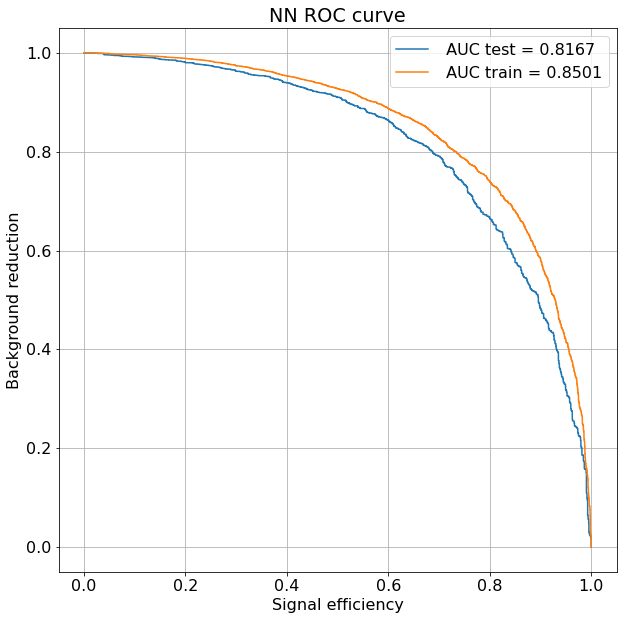

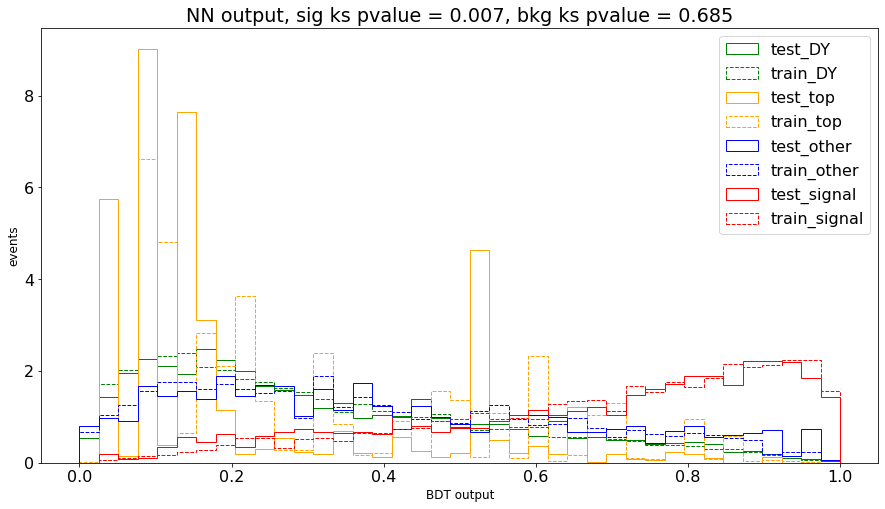

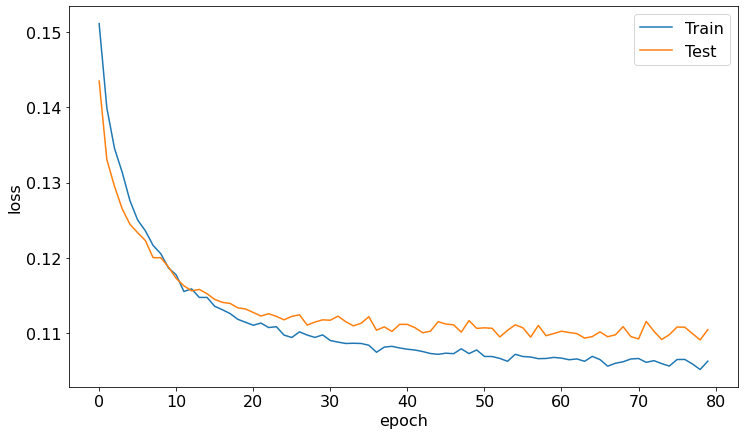

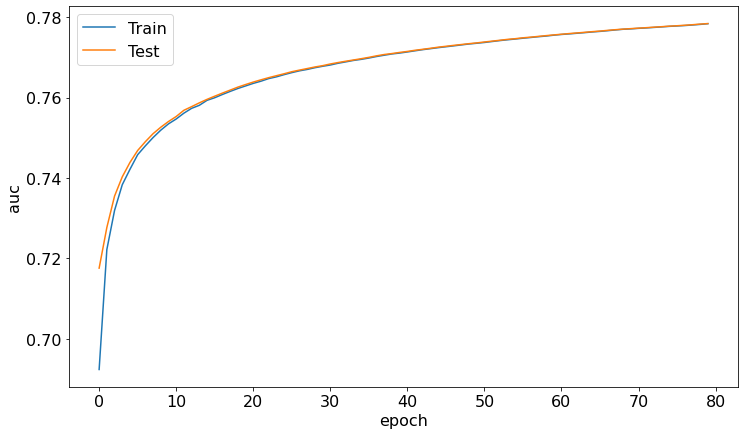

In [7]:
#plot results
from sklearn.metrics import auc, roc_curve
from keras.models import load_model
#model = load_model(res_dir+'\\model.h5')
model=DNN
predictions_NN= model.predict(X_test)
predictions_NN_train=model.predict(X_train)

#KS_test

from scipy import stats
ks_test_sig=stats.ks_2samp(predictions_NN[:,0][y_test['signal'] ==1],predictions_NN_train[:,0][y_train['signal'] ==1])
ks_test_bkg=stats.ks_2samp(predictions_NN[:,0][y_test['signal'] ==0],predictions_NN_train[:,0][y_train['signal'] ==0])

#plot AUC
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),predictions_NN, pos_label=1, sample_weight=y_test['weight_'])
tpr.sort()
fpr.sort()
roc_auc =auc(fpr, tpr)
print ("AUC Score (Test): {:4%}".format(roc_auc))
plt.plot(tpr,(1-fpr), label =' AUC test = %0.4f' %(roc_auc))
fpr, tpr, threshold = roc_curve(y_train['signal'].astype('int32'),predictions_NN_train, pos_label=1, sample_weight=y_train['weight_'])
tpr.sort()
fpr.sort()
roc_auc =auc(fpr, tpr)
print ("AUC Score (Test): {:4%}".format(roc_auc))
plt.plot(tpr,(1-fpr), label =' AUC train = %0.4f' %(roc_auc))
#plt.xlim(0,0.3)
plt.xlabel('Signal efficiency')
plt.ylabel('Background reduction')
plt.title('NN ROC curve')
plt.grid()
plt.legend()
plt.savefig(res_dir+'\\{}{}_{}_NNROC.png'.format(year,vers,cut))

#plot NN ouput by sample
plt.figure(figsize=(15,8))
groups=['DY','top','other','signal']
color=['green', 'orange','blue','red']
x=[]
nbins=40
for i,group in enumerate(groups):  
    plt.hist(predictions_NN[y_test['group']==group],bins=np.linspace(0,1,nbins), label='test_'+group, density=True, histtype='step', color=color[i], weights= y_test['weight_'][y_test['group']==group])
    plt.hist(predictions_NN_train[y_train['group']==group],bins=np.linspace(0,1,nbins), label='train_'+group, density=True, histtype='step', color=color[i], linestyle='dashed',weights= y_train['weight_'][y_train['group']==group])

plt.xlabel('BDT output',fontsize=12)
plt.ylabel('events',fontsize=12)
plt.title('NN output, sig ks pvalue = {:.3f}, bkg ks pvalue = {:.3f}'.format(ks_test_sig[1], ks_test_bkg[1]))
plt.legend()
plt.savefig(res_dir+'\\{}{}_{}_NNOutput_Trainvstest.png'.format(year,vers,cut))


#plot loss
plt.figure(figsize=(12,7))
epochs = len(history.history['val_loss'])
x_axis = range(0, epochs)
#fig, ax = plt.subplots()
plt.plot(x_axis, history.history['loss'], label='Train')
plt.plot(x_axis, history.history['val_loss'], label='Test')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.draw()
plt.savefig(res_dir+'\\{}{}_{}_NNloss.png'.format(year,vers,cut))

plt.figure(figsize=(12,7))
epochs = len(history.history['val_auc'])
x_axis = range(0, epochs)
#fig, ax = plt.subplots()
plt.plot(x_axis, history.history['auc'], label='Train')
plt.plot(x_axis, history.history['val_auc'], label='Test')
plt.legend()
plt.ylabel('auc')
plt.xlabel('epoch')
plt.draw()
plt.savefig(res_dir+'\\{}{}_{}_NNauc.png'.format(year,vers,cut))

#plot SoB
"""
epochs = len(history.history['val_tp'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, (history.history['tp']/np.sqrt(history.history['fp'])), label='Train')
ax.plot(x_axis, (history.history['val_tp']/np.sqrt(history.history['val_fp'])), label='Test')
ax.legend()
plt.ylabel('SoB')
plt.xlabel('epoch')
plt.draw()
plt.savefig(res_dir+'\\{}{}_{}_NNSoB.png'.format(year,vers,cut))
"""


In [8]:
#predict every x epoch

DNN, NN_name=build_dnn(base_dir, lr, l1, l2, dp, sl1, sl2, sl3, sl4, sl5)
res_dir=base_dir+'\\'+year+'\\'+cut+'\\Res_{}'.format(NN_name)+vers
freq = 3
predictions_test={}
predictions_train={}

history={}
i=0
DNN, NN_name=build_dnn(base_dir, lr, l1, l2, dp, sl1, sl2, sl3, sl4, sl5)
history[i]=DNN.fit(x=X_train, y=y_train['signal'].to_numpy(),
                   sample_weight=y_train['w'].to_numpy(), epochs = freq, batch_size=batchsize, 
            verbose=2, validation_data=(X_test, y_test['signal'].to_numpy(),y_test['w'].to_numpy()))

predictions_test[i]=DNN.predict(X_test)
predictions_train[i]=DNN.predict(X_train)

for i in range (1, int(epochs/freq)):
    print("training {}/{}".format(i, int(epochs/freq)))
    history[i]=DNN.fit(x=X_train, y=y_train['signal'].to_numpy(),
                sample_weight=y_train['w'].to_numpy(), epochs = freq, batch_size=batchsize, 
                verbose=2, 
                validation_data=(X_test, y_test['signal'].to_numpy(),y_test['w'].to_numpy()))
    predictions_test[i]=DNN.predict(X_test)
    predictions_train[i]=DNN.predict(X_train)
   
    

Train on 44647 samples, validate on 11162 samples
Epoch 1/3
 - 1s - loss: 0.1567 - auc_2: 0.6288 - val_loss: 0.1420 - val_auc_2: 0.6861
Epoch 2/3
 - 1s - loss: 0.1409 - auc_2: 0.7000 - val_loss: 0.1335 - val_auc_2: 0.7100
Epoch 3/3
 - 1s - loss: 0.1352 - auc_2: 0.7171 - val_loss: 0.1296 - val_auc_2: 0.7220
training 1/26
Train on 44647 samples, validate on 11162 samples
Epoch 1/3
 - 1s - loss: 0.1311 - auc_2: 0.7259 - val_loss: 0.1276 - val_auc_2: 0.7289
Epoch 2/3
 - 1s - loss: 0.1281 - auc_2: 0.7314 - val_loss: 0.1257 - val_auc_2: 0.7336
Epoch 3/3
 - 1s - loss: 0.1261 - auc_2: 0.7356 - val_loss: 0.1236 - val_auc_2: 0.7374
training 2/26
Train on 44647 samples, validate on 11162 samples
Epoch 1/3
 - 1s - loss: 0.1231 - auc_2: 0.7394 - val_loss: 0.1217 - val_auc_2: 0.7409
Epoch 2/3
 - 1s - loss: 0.1212 - auc_2: 0.7422 - val_loss: 0.1208 - val_auc_2: 0.7437
Epoch 3/3
 - 1s - loss: 0.1199 - auc_2: 0.7453 - val_loss: 0.1201 - val_auc_2: 0.7461
training 3/26
Train on 44647 samples, validate o

Epoch 2/3
 - 1s - loss: 0.1066 - auc_2: 0.7761 - val_loss: 0.1104 - val_auc_2: 0.7762
Epoch 3/3
 - 1s - loss: 0.1070 - auc_2: 0.7762 - val_loss: 0.1106 - val_auc_2: 0.7763


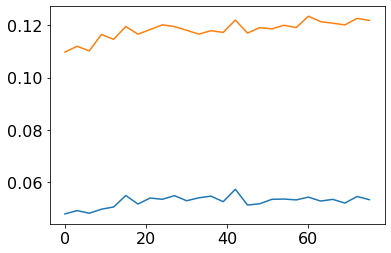

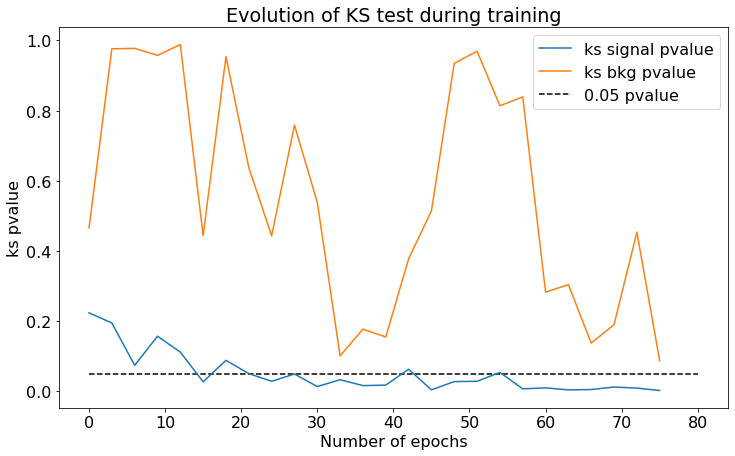

In [9]:
from scipy import stats
i = 0
ks_sig={}
ks_bkg={}
ks_sig[i]=stats.ks_2samp(predictions_test[i][:,0][y_test['signal'] ==1],predictions_train[i][:,0][y_train['signal'] ==1])[1]
ks_bkg[i]=stats.ks_2samp(predictions_test[i][:,0][y_test['signal'] ==0],predictions_train[i][:,0][y_train['signal'] ==0])[1]
S_test={}
B_test={}
S_train={}
B_train={}
co=0.8
S_test[i]=sum(y_test['weight_'][predictions_test[i][:,0]>=co][y_test['signal'][predictions_test[i][:,0]>=co] == 1])
S_train[i]=sum(y_train['weight_'][predictions_train[i][:,0]>=co][y_train['signal'][predictions_train[i][:,0]>=co] == 1])
B_test[i]=sum(y_test['weight_'][predictions_test[i][:,0]>=co][y_test['signal'][predictions_test[i][:,0]>=co] == 0])
B_train[i]=sum(y_train['weight_'][predictions_train[i][:,0]>=co][y_train['signal'][predictions_train[i][:,0]>=co] == 0])

for i in range (1, int(epochs/freq)):
    ks_sig[i]=stats.ks_2samp(predictions_test[i][:,0][y_test['signal'] ==1],predictions_train[i][:,0][y_train['signal'] ==1])[1]
    ks_bkg[i]=stats.ks_2samp(predictions_test[i][:,0][y_test['signal'] ==0],predictions_train[i][:,0][y_train['signal'] ==0])[1]
    S_test[i]=sum(y_test['weight_'][predictions_test[i][:,0]>=co][y_test['signal'][predictions_test[i][:,0]>=co] == 1])
    S_train[i]=sum(y_train['weight_'][predictions_train[i][:,0]>=co][y_train['signal'][predictions_train[i][:,0]>=co] == 1])
    B_test[i]=sum(y_test['weight_'][predictions_test[i][:,0]>=co][y_test['signal'][predictions_test[i][:,0]>=co] == 0])
    B_train[i]=sum(y_train['weight_'][predictions_train[i][:,0]>=co][y_train['signal'][predictions_train[i][:,0]>=co] == 0])


SoB_test=[]
SoB_train=[]
for i in range(0, len(S_test.values())):
    #print (S_test[i], B_test[i])
    SoB_test.append((S_test[i]/np.sqrt(B_test[i])))
    SoB_train.append((S_train[i]/np.sqrt(B_train[i])))
x=[i*freq for i in range(0, len(ks_sig))]
plt.plot(x, SoB_test)
plt.plot(x, SoB_train)
plt.savefig(res_dir+'\\{}{}_{}_SOB.png'.format(year,vers,cut))

plt.figure(figsize=(12,7))
x=[i*freq for i in range(0, len(ks_sig))]
plt.plot(x, ks_sig.values(), label ="ks signal pvalue")
plt.plot(x, ks_bkg.values(),label="ks bkg pvalue")
plt.hlines(0.05, 0, epochs, label = "0.05 pvalue", linestyle = "--", color = 'k')
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("ks pvalue")
plt.ylim=(0,1)
plt.title("Evolution of KS test during training")
plt.savefig(res_dir+'\\{}{}_{}_ks.png'.format(year,vers,cut))